In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("RegressaoLinearPeixes").getOrCreate()

# Carregando o dataset Fish.csv
dados = spark.read.csv("Fish.csv", header=True, inferSchema=True)
dados.show(5)

+-------+------+-------+-------+-------+-------+------+
|Species|Weight|Length1|Length2|Length3| Height| Width|
+-------+------+-------+-------+-------+-------+------+
|  Bream| 242.0|   23.2|   25.4|   30.0|  11.52|  4.02|
|  Bream| 290.0|   24.0|   26.3|   31.2|  12.48|4.3056|
|  Bream| 340.0|   23.9|   26.5|   31.1|12.3778|4.6961|
|  Bream| 363.0|   26.3|   29.0|   33.5|  12.73|4.4555|
|  Bream| 430.0|   26.5|   29.0|   34.0| 12.444| 5.134|
+-------+------+-------+-------+-------+-------+------+
only showing top 5 rows



In [8]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['Length1','Height', 'Width'], outputCol='features')
dados_simples = assembler.transform(dados)
dados_simples.show()

+-------+------+-------+-------+-------+-------+------+--------------------+
|Species|Weight|Length1|Length2|Length3| Height| Width|            features|
+-------+------+-------+-------+-------+-------+------+--------------------+
|  Bream| 242.0|   23.2|   25.4|   30.0|  11.52|  4.02|   [23.2,11.52,4.02]|
|  Bream| 290.0|   24.0|   26.3|   31.2|  12.48|4.3056| [24.0,12.48,4.3056]|
|  Bream| 340.0|   23.9|   26.5|   31.1|12.3778|4.6961|[23.9,12.3778,4.6...|
|  Bream| 363.0|   26.3|   29.0|   33.5|  12.73|4.4555| [26.3,12.73,4.4555]|
|  Bream| 430.0|   26.5|   29.0|   34.0| 12.444| 5.134| [26.5,12.444,5.134]|
|  Bream| 450.0|   26.8|   29.7|   34.7|13.6024|4.9274|[26.8,13.6024,4.9...|
|  Bream| 500.0|   26.8|   29.7|   34.5|14.1795|5.2785|[26.8,14.1795,5.2...|
|  Bream| 390.0|   27.6|   30.0|   35.0|  12.67|  4.69|   [27.6,12.67,4.69]|
|  Bream| 450.0|   27.6|   30.0|   35.1|14.0049|4.8438|[27.6,14.0049,4.8...|
|  Bream| 500.0|   28.5|   30.7|   36.2|14.2266|4.9594|[28.5,14.2266,4.9...|

In [11]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="Weight")
modelo_treinado_simples = lr.fit(dados_simples)

In [12]:
print("RMSE (modelo simples):", modelo_treinado_simples.summary.rootMeanSquaredError)
print("R² (modelo simples):", modelo_treinado_simples.summary.r2)

RMSE (modelo simples): 122.29167129930637
R² (modelo simples): 0.8825588337732082


In [15]:
previsoes = modelo_treinado_simples.transform(dados_simples).select("Weight", "prediction")


In [18]:
previsoes.show(10)

+------+------------------+
|Weight|        prediction|
+------+------------------+
| 242.0|346.53591956089656|
| 290.0|  390.391463848821|
| 340.0| 403.9349589040896|
| 363.0|  452.585544284203|
| 430.0|483.11317562677334|
| 450.0| 496.6487406556506|
| 500.0| 520.0102327736106|
| 390.0|491.58724709346643|
| 450.0| 516.6130795581407|
| 500.0| 545.1526768101335|
+------+------------------+
only showing top 10 rows



In [ ]:
import matplotlib.pyplot as plt

# Aplicar modelo ao dataset completo
previsoes = modelo_treinado_completo.transform(dados_completo).select("Weight", "prediction")

# Coletar dados
valores_reais = [row["Weight"] for row in previsoes.collect()]
valores_previstos = [row["prediction"] for row in previsoes.collect()]
residuos = [real - pred for real, pred in zip(valores_reais, valores_previstos)]

# Gráfico de resíduos
plt.figure(figsize=(10,5))
plt.scatter(valores_previstos, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Resíduos vs Previsões")
plt.xlabel("Peso Previsto")
plt.ylabel("Resíduo (Peso Real - Previsto)")
plt.grid(True)
plt.show()

In [24]:
dados_treino,dados_teste = dados_simples.randomSplit([0.8,0.2],seed=42)

In [38]:
df1, df2, df3 = dados_simples.randomSplit([0.7,0.2,0.1],seed=42)

In [25]:
modelo_split = LinearRegression(featuresCol="features", labelCol="Weight")
modelo_treinado_split = modelo_split.fit(dados_treino)

In [26]:
previsoes_teste = modelo_treinado_split.transform(dados_teste)
previsoes_teste.select("Weight", "prediction").show(5)

+------+------------------+
|Weight|        prediction|
+------+------------------+
| 340.0|426.03839119625536|
| 430.0|497.14223891821337|
| 450.0| 514.7275687125081|
| 500.0| 495.6607841181875|
| 650.0| 637.4375085959076|
+------+------------------+
only showing top 5 rows



In [30]:
from pyspark.ml.evaluation import RegressionEvaluator
avaliador = RegressionEvaluator(labelCol="Weight", predictionCol="prediction", metricName="rmse")
rmse_teste = avaliador.evaluate(previsoes_teste)

avaliador_r2 = RegressionEvaluator(labelCol="Weight", predictionCol="prediction", metricName="r2")
r2_teste = avaliador_r2.evaluate(previsoes_teste)

print("RMSE (teste):", rmse_teste)
print("R² (teste):", r2_teste)

RMSE (teste): 229.6949406666493
R² (teste): 0.790293985732079


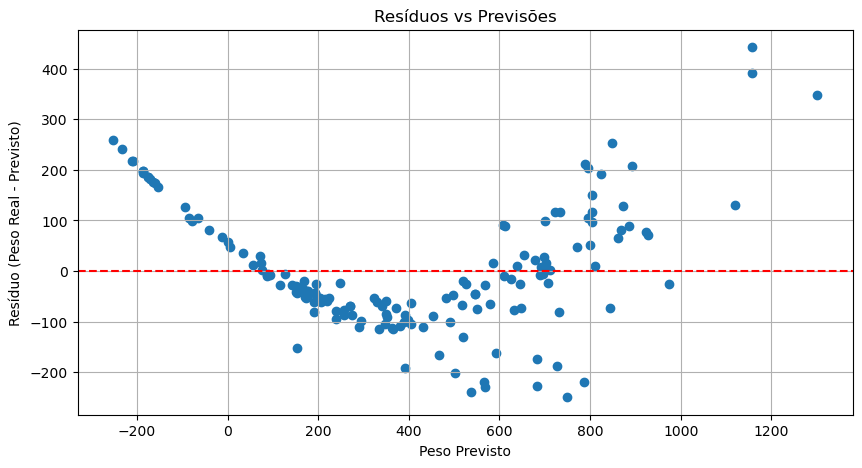

In [34]:
import matplotlib.pyplot as plt

# Aplicar modelo ao dataset completo
previsoes = modelo_treinado_simples.transform(dados_simples).select("Weight", "prediction")

# Coletar dados
valores_reais = [row["Weight"] for row in previsoes.collect()]
valores_previstos = [row["prediction"] for row in previsoes.collect()]
residuos = [real - pred for real, pred in zip(valores_reais, valores_previstos)]

# Gráfico de resíduos
plt.figure(figsize=(10,5))
plt.scatter(valores_previstos, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Resíduos vs Previsões")
plt.xlabel("Peso Previsto")
plt.ylabel("Resíduo (Peso Real - Previsto)")
plt.grid(True)
plt.show()